In [115]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-12-15 03:18:45--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2019-12-15 03:18:46 (303 KB/s) - ‘loan_train.csv’ saved [23101/23101]



In [116]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

In [117]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [118]:
df.shape

(346, 10)

In [119]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

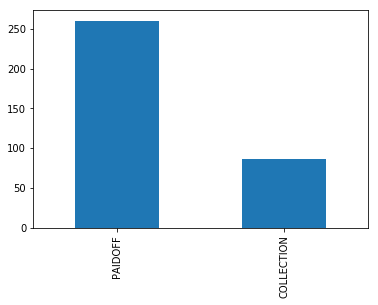

In [120]:
df['loan_status'].value_counts().plot(kind='bar')

260 people have paid off the loan on time while 86 have gone into collectio

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
Unnamed: 0        346 non-null int64
Unnamed: 0.1      346 non-null int64
loan_status       346 non-null object
Principal         346 non-null int64
terms             346 non-null int64
effective_date    346 non-null object
due_date          346 non-null object
age               346 non-null int64
education         346 non-null object
Gender            346 non-null object
dtypes: int64(5), object(5)
memory usage: 27.1+ KB


In [122]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')

In [123]:
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'],axis=1)

In [124]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


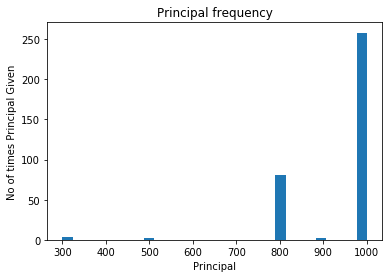

In [125]:

def labellingPlot(xlabel,ylabel,title):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
df.Principal.plot(kind = 'hist',bins =30)
labellingPlot('Principal','No of times Principal Given','Principal frequency')

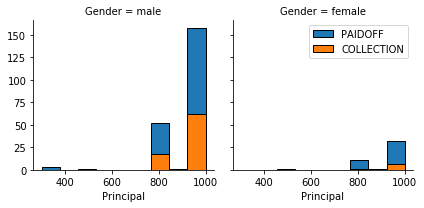

In [126]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

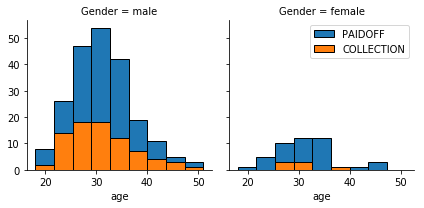

In [127]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

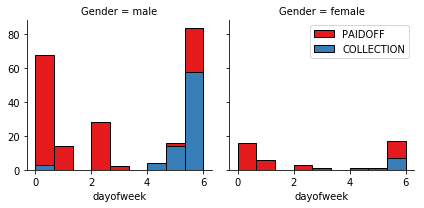

In [128]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4

In [129]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df['Difference_effective_due_date'] = (df['due_date'] - df['effective_date']).dt.days
df['Difference_effective_due_date']
print(df.groupby(['Difference_effective_due_date'])['loan_status'].value_counts(normalize=True))
df.head()

Difference_effective_due_date  loan_status
6                              PAIDOFF        1.000000
13                             PAIDOFF        1.000000
14                             PAIDOFF        0.784173
                               COLLECTION     0.215827
29                             PAIDOFF        0.721591
                               COLLECTION     0.278409
44                             PAIDOFF        0.600000
                               COLLECTION     0.400000
59                             PAIDOFF        0.583333
                               COLLECTION     0.416667
Name: loan_status, dtype: float64


,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,Difference_effective_due_date
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0,29
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0,29
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0,14
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1,29
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1,29


In [130]:
#print(len(df.groupby(['Gender','loan_status'])))
print(df.groupby(['Gender'])['loan_status'].value_counts())
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF         45
        COLLECTION       7
male    PAIDOFF        215
        COLLECTION      79
Name: loan_status, dtype: int64


Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

## Convert Categorical features to numerical values

In [131]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,Difference_effective_due_date
0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,29
1,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,29
2,1,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,14
3,1,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,29
4,1,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,29


## One Hot Encoding  

In [132]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              1              0.750000
                      0              0.250000
High School or Below  1              0.741722
                      0              0.258278
Master or Above       0              0.500000
                      1              0.500000
college               1              0.765101
                      0              0.234899
Name: loan_status, dtype: float64

In [133]:
df[['Principal','terms','age','Gender','education','Difference_effective_due_date']].head()
#df[['Principal','terms','age','Gender','education']].head()


,Principal,terms,age,Gender,education,Difference_effective_due_date
0,1000,30,45,0,High School or Below,29
1,1000,30,33,1,Bechalor,29
2,1000,15,27,0,college,14
3,1000,30,28,1,college,29
4,1000,30,29,0,college,29


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [134]:
Feature = df[['Principal','terms','age','Gender','weekend','Difference_effective_due_date']]
#Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Difference_effective_due_date,Bechalor,High School or Below,college
0,1000,30,45,0,0,29,0,1,0
1,1000,30,33,1,0,29,1,0,0
2,1000,15,27,0,0,14,0,0,1
3,1000,30,28,1,1,29,0,0,1
4,1000,30,29,0,1,29,0,0,1


## Feature selection

In [135]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Difference_effective_due_date,Bechalor,High School or Below,college
0,1000,30,45,0,0,29,0,1,0
1,1000,30,33,1,0,29,1,0,0
2,1000,15,27,0,0,14,0,0,1
3,1000,30,28,1,1,29,0,0,1
4,1000,30,29,0,1,29,0,0,1


our lables

In [136]:
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1])

## Normalize Data 

Data Standardization give data zero mean and unit variance

In [137]:
X= preprocessing.StandardScaler().fit(X).transform(X)
#sc=preprocessing.StandardScaler()
#X=sc.fit_transform(X)
#X= preprocessing.MinMaxScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
         0.53257725, -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         0.53257725,  2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.88417105, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
         0.53257725, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
         0.53257725, -0.38170062, -0.87997669,  1.14984679]])

In [138]:
from sklearn.model_selection import train_test_split
#splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)
print(X_train.shape,X_test.shape)

(311, 9) (35, 9)


# Classification 

In [139]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(solver='lbfgs')
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}# l1 lasso l2 ridge
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)


print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.7395498392282959


In [140]:
from sklearn.linear_model import LogisticRegression
clflr = LogisticRegression(C=0.001,penalty='l2')
clflr.fit(X_train, y_train)
y_pred = clflr.predict(X_test)

print("Model 4: Log_reg Train set Accuracy: ", metrics.accuracy_score(y_train, clflr.predict(X_train)))
print("Model 4: Log_reg Validation set Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Model 4: Log_reg Jaccard Score:",jaccard_similarity_score(y_test, y_pred))
print("Model 4: Log_reg F1 Score", f1_score(y_test, y_pred))
print("Model 4: Log_reg log_loss Score", log_loss(y_test, y_pred))

Model 4: Log_reg Train set Accuracy:  0.7363344051446945
Model 4: Log_reg Validation set Accuracy:  0.6285714285714286
Model 4: Log_reg Jaccard Score: 0.6285714285714286
Model 4: Log_reg F1 Score 0.7450980392156863
Model 4: Log_reg log_loss Score 12.828734066534265


In [141]:
#from sklearn import svm
#clf = svm.SVC(kernel='linear')
from sklearn.svm import SVC
clfsvm = SVC(kernel='linear')
clfsvm.fit(X_train, y_train)
y_pred = clfsvm.predict(X_test)

print("Model 3: SVM Train set Accuracy: ", metrics.accuracy_score(y_train, clfsvm.predict(X_train)))
print("Model 3: SVM Validation set Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Model 3: SVM Jaccard Score:",jaccard_similarity_score(y_test, y_pred))
print("Model 3: SVM F1 Score", f1_score(y_test, y_pred))

Model 3: SVM Train set Accuracy:  0.7491961414790996
Model 3: SVM Validation set Accuracy:  0.8285714285714286
Model 3: SVM Jaccard Score: 0.8285714285714286
Model 3: SVM F1 Score 0.9032258064516129


In [142]:
from sklearn import tree
clfdt = tree.DecisionTreeClassifier(criterion="entropy", max_depth = 5)
clfdt.fit(X_train, y_train)
y_pred = clfdt.predict(X_test)

print("Model 2: D_tree Train set Accuracy: ", metrics.accuracy_score(y_train, clfdt.predict(X_train)))
print("Model 2: D_tree Validation set Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Model 2: D_tree Jaccard Score:",jaccard_similarity_score(y_test, y_pred))
print("Model 2: D_tree F1 Score", f1_score(y_test, y_pred))

Model 2: D_tree Train set Accuracy:  0.7781350482315113
Model 2: D_tree Validation set Accuracy:  0.7428571428571429
Model 2: D_tree Jaccard Score: 0.7428571428571429
Model 2: D_tree F1 Score 0.847457627118644


In [143]:
#import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors':np.arange(1,10)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)
print(knn_cv.best_score_)
print(knn_cv.best_params_)

0.7202572347266881
{'n_neighbors': 3}


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [144]:
clfnbr = KNeighborsClassifier(n_neighbors=3)
clfnbr.fit(X_train, y_train)
y_pred = clfnbr.predict(X_test)

print("Model 1: KNN Train set Accuracy: ", metrics.accuracy_score(y_train, clfnbr.predict(X_train)))
print("Model 1: KNN Validation set Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Model 1: KNN Jaccard Score:",jaccard_similarity_score(y_test, y_pred))
print("Model 1: KNN F1 Score", f1_score(y_test, y_pred))

Model 1: KNN Train set Accuracy:  0.8392282958199357
Model 1: KNN Validation set Accuracy:  0.7428571428571429
Model 1: KNN Jaccard Score: 0.7428571428571429
Model 1: KNN F1 Score 0.8363636363636363


## Model Evaluation using Test set

In [145]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-12-15 03:18:51--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-12-15 03:18:51 (348 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [146]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [147]:
test_df.drop(['Unnamed: 0','Unnamed: 0.1'],inplace=True,axis=1)
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [148]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
#df['loan_status']=np.where(df['loan_status']=='COLLECTION',1,0)
#df['Gender']=np.where(df['Gender']=='male',1,0)
test_df.head()
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Difference_effective_due_date'] = (df['due_date'] - df['effective_date']).dt.days
test_df['Difference_effective_due_date']
Feature = test_df[['Principal','terms','age','Gender','weekend','Difference_effective_due_date']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)



In [149]:
y_true = test_df['loan_status'].values
X_test = preprocessing.StandardScaler().fit(Feature).transform(Feature)
#X_test= preprocessing.MinMaxScaler().fit(X_test).transform(X_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [150]:
KNN_j = jaccard_similarity_score(y_true,clfnbr.predict(X_test))
KNN_f1 = f1_score(y_true,clfnbr.predict(X_test))
dtree_j = jaccard_similarity_score(y_true,clfdt.predict(X_test))
dtree_f1 = f1_score(y_true,clfdt.predict(X_test))
svm_j = jaccard_similarity_score(y_true,clfsvm.predict(X_test))
svm_f1 = f1_score(y_true,clfsvm.predict(X_test))
logreg_j = jaccard_similarity_score(y_true,clflr.predict(X_test))
logreg_f1 = f1_score(y_true,clflr.predict(X_test))
logreg_loss = log_loss(y_true, clflr.predict(X_test))

In [151]:
col_names =  ['Algorithm','Jaccard', 'F1-score','LogLoss','recommendation']
Report_df = pd.DataFrame(columns = col_names)
Report_df.loc[len(Report_df)] = ['KNN', KNN_j,KNN_f1,'NA','']
Report_df.loc[len(Report_df)] = ['Decision Tree', dtree_j,dtree_f1,'NA','Best Fit']
Report_df.loc[len(Report_df)] = ['SVM', svm_j,svm_f1,'NA','']
Report_df.loc[len(Report_df)] = ['Log_Reg', logreg_j,logreg_f1,logreg_loss,'']
Report_df

,Algorithm,Jaccard,F1-score,LogLoss,recommendation
0,KNN,0.611111,0.727273,NA,
1,Decision Tree,0.759259,0.847059,NA,Best Fit
2,SVM,0.611111,0.734177,NA,
3,Log_Reg,0.777778,0.863636,7.67543,


## Conclusion
#### Decision Tree Model has the best fit with 75% test accuracy and F1 score of .85